United States market

Price to Cash flow from 10 to 20

In [1]:
import sys

import pandas
import sklearn
import sklearn.tree
import sklearn.cluster
import sklearn.preprocessing

sys.path.append('investpy')

import investpy
import random
import numpy as np
import scipy
import scipy.stats
import pandas_ta
import traceback

In [2]:
n = 50
index = 'NASDAQ'
country = "United States"
date_from = "01/09/2019"
date_to = "01/09/2020"

In [3]:
index_data = investpy.indices.get_index_historical_data(index, country, date_from, date_to)
correct_days = len(index_data)
print(f"Days in period: {correct_days}")

Days in period: 253


In [4]:
class StockData:
  def calculate_rsi(self, periods = 14, ema = True):
    close_delta = self.data.loc[:, 'Close'].diff()

    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)

    if ema:
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

  def calculate_info(self):
    self.average = self.close.mean()
    self.abs_growth = self.close[-1] - self.close[0]
    self.rel_growth = self.abs_growth/self.close[0]
    self.abs_growth_to_rel_growth = self.abs_growth/self.rel_growth
    self.variance = self.close.std() / self.average
    self.range = self.close.max() - self.close.min()
    self.range_ln = np.log(self.range)
    self.oscillation = self.average / self.range

    self.stock_diff = np.array([(self.close[i]/self.close[i-1])-1 for i in range(1, len(self.close))])
    self.profit_avg = self.stock_diff.mean()
    self.profit_var = self.stock_diff.std()

    self.ratios = investpy.stocks.get_stock_ratios(self.stock, self.country)

    self.debt_to_equity = self.ratios["Total Debt to Equity"].to_numpy()[0]
    if np.isnan(self.debt_to_equity):
        raise ValueError("Debt to equity is nan")

    self.basic_eps = self.ratios["Basic EPS"].to_numpy()[0]
    if np.isnan(self.basic_eps):
        raise ValueError("Basic EPS is nan")

    self.pe_ratio = self.ratios["P/E Ratio"].to_numpy()[0]
    if np.isnan(self.pe_ratio):
        raise ValueError("Basic EPS is nan")

    self.dividend_yield = self.ratios["Dividend Yield"].to_numpy()[0]
    if np.isnan(self.dividend_yield):
        raise ValueError("Dividend Yeild is nan")

    self.current_ratio = self.ratios["Current Ratio"].to_numpy()[0]
    if np.isnan(self.current_ratio):
        raise ValueError("Current Ratio is nan")

    self.roe = self.ratios["Return on Equity"].to_numpy()[0]
    if np.isnan(self.roe):
        raise ValueError("Return on Equity is nan")


    self.rsi = pandas_ta.rsi(self.data['Close'], length = correct_days-1).iloc[-1]
    self.volatility = self.close.std()

    self.beta = np.correlate(self.close, index_data['Close'].to_numpy())[0]/np.std(index_data['Close'].to_numpy())

    # index_data.loc[:, 'Close'].to_numpy()

    self.spearman = scipy.stats.spearmanr(self.close, list(range(len(self.close)))).correlation
    # stability of quotes to2810.xlsx candles (22)
    # делаем линейную регрессию, считаем квадраты отклонений от неё, stability of quoates = 1 - среднеквадратичное отклонение / сумму квадратов отклонений

    # stability = среднее положительных приростов / среднеее отрицательных приростов
    # rsi = количество положительных приростов / количество отрицательных приростов

  def __init__(self, stock, country, date_from, date_to, data):
    self.stock = stock
    self.country = country
    self.date_from = date_from
    self.date_to = date_to
    self.data = data
    self.close = data.loc[:, 'Close'].to_numpy()
    self.calculate_info()

  def __repr__(self):
    return f"""
stock: {self.stock},
country: {self.country},
date_from: {self.date_from},
date_to: {self.date_to},
data: 
{self.data.head()}"""

In [5]:
def get_stock_historical_data(stock,
                              country,
                              from_date,
                              to_date):
  df = investpy.get_stock_historical_data(stock=stock,
                                          country=country,
                                          from_date=from_date,
                                          to_date=to_date,
                                          order='ascending',
                                          interval="Daily")
  return df.loc[:, ['Open', 'High', 'Low', 'Close']]

In [6]:
def get_random_stock_data_n(n, countries, date_from, date_to, correct_days, debug=False):
  stocks = []
  for country in countries:
    country_stocks = investpy.get_stocks_list(country)
    country_stocks = list(filter(lambda s: not s.endswith("_p"), country_stocks)) # _p is privileged stock
    country_stocks = zip(country_stocks, [country] * len(country_stocks))
    stocks += country_stocks
  random.shuffle(stocks)
  stock_data = []
  for (stock, country) in stocks:
    try:
      data = get_stock_historical_data(stock, country, date_from, date_to)
      stock_datum = StockData(stock, country, date_from, date_to, data)
      if len(stock_datum.close) != correct_days:
        continue
#       if stock_datum.profit_avg < 0:
#         continue
      stock_data.append(stock_datum)
      print(f"{len(stock_data)}/{n}")
    except Exception as e:
      if debug:
          traceback.print_exc()
        # print(e)
      # possibly, not available in selected date interval
    if len(stock_data) >= n:
      break
  return stock_data

In [7]:
def get_screener_stock_data_n(n, selected_stocks, country, date_from, date_to, correct_days, debug=False):
    stock_data = []
    for stock in selected_stocks:
        try:
            data = get_stock_historical_data(stock, country, date_from, date_to)
            if len(data.loc[:, 'Close']) != correct_days:
                continue
            stock_datum = StockData(stock, country, date_from, date_to, data)
            stock_data.append(stock_datum)
            print(f"{len(stock_data)}/{n}")
        except Exception as e:
            if debug:
                traceback.print_exc()
            # possibly, not available in selected date interval
        if len(stock_data) >= n:
            break
    return stock_data

In [8]:
def get_stock_data(method: str = 'screener', debug=False):
    if method == 'random':
        stock_data = get_random_stock_data_n(n, [country], date_from, date_to, correct_days, debug=debug)
    elif method == 'screener':
        selected_stocks_df = investpy.screener(
            investpy.ScreenerParams()
                .with_country(country)
                .add_filter("Price to Cash Flow (MRQ)", 10, 20),
            as_dataframe=True, n_results=300)
        selected_stocks = selected_stocks_df['symbol'].to_numpy()
        selected_stocks = list(set(selected_stocks))
        stock_data = get_screener_stock_data_n(n, selected_stocks, country, date_from, date_to, correct_days, debug=debug)
    else:
        raise ValueError(f"Unexpected method {method}")
    print(f"Selected {len(stock_data)} stocks: {list(map(lambda x: x.stock, stock_data))}")

    return stock_data

In [9]:
stock_data = get_stock_data('screener', debug=False)

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50
Selected 50 stocks: ['FUL', 'NTTYY', 'GEFb', 'BTI', 'AIR', 'HCMLY', 'ERIC', 'HNNA', 'NWL', 'GOLD', 'TS', 'ATHM', 'HMC', 'RDSb', 'RDSa', 'AROC', 'SAH', 'ASTE', 'CTSH', 'RS', 'BCEI', 'ADRNY', 'COKE', 'BWA', 'BBL', 'CEO', 'ODC', 'ASH', 'AIMC', 'SSL', 'LCUT', 'B', 'RCKY', 'CRH', 'NWSA', 'IBA', 'ACCO', 'ALG', 'BGS', 'AGCO', 'BHP', 'WBRBY', 'ADTN', 'ALV', 'APOG', 'TELNY', 'ORAN', 'CBRL', 'BRDCY', 'AMGN']


In [10]:
from scipy.optimize import Bounds, minimize
import numpy as np
import matplotlib.pyplot as plt

labels =      list(map(lambda x: x.stock, stock_data))
mu = np.array(list(map(lambda x: 100*x.profit_avg, stock_data)))

var = np.array(list(map(lambda x: x.profit_var, stock_data)))

R = np.corrcoef(np.array(list(map(lambda x: x.stock_diff, stock_data))))

var = np.expand_dims(var, axis=0)
S = var.T @ var * R
# Initial guess
x = np.ones(len(labels)) * (1/len(labels))

def value(x):
        return x.T @ S @ x

def optimize_portfolio(r):
    mu_cons = {'type': 'eq',
                 'fun': lambda x: np.sum(mu @ x.T) - r
                }
    sum_cons = {'type': 'eq',
                 'fun': lambda x: np.sum(x) - 1
                }
    bnds = Bounds (np.ones_like(x) * 0.0, np.ones_like(x))

    res = minimize(value, x, method='SLSQP', 
                   constraints=[mu_cons, sum_cons], bounds=bnds)
    return res

rate = np.linspace(0, 1, 100)
opti = list(map(optimize_portfolio, rate))
y = np.array(list(map(lambda res: res.x, opti))).T

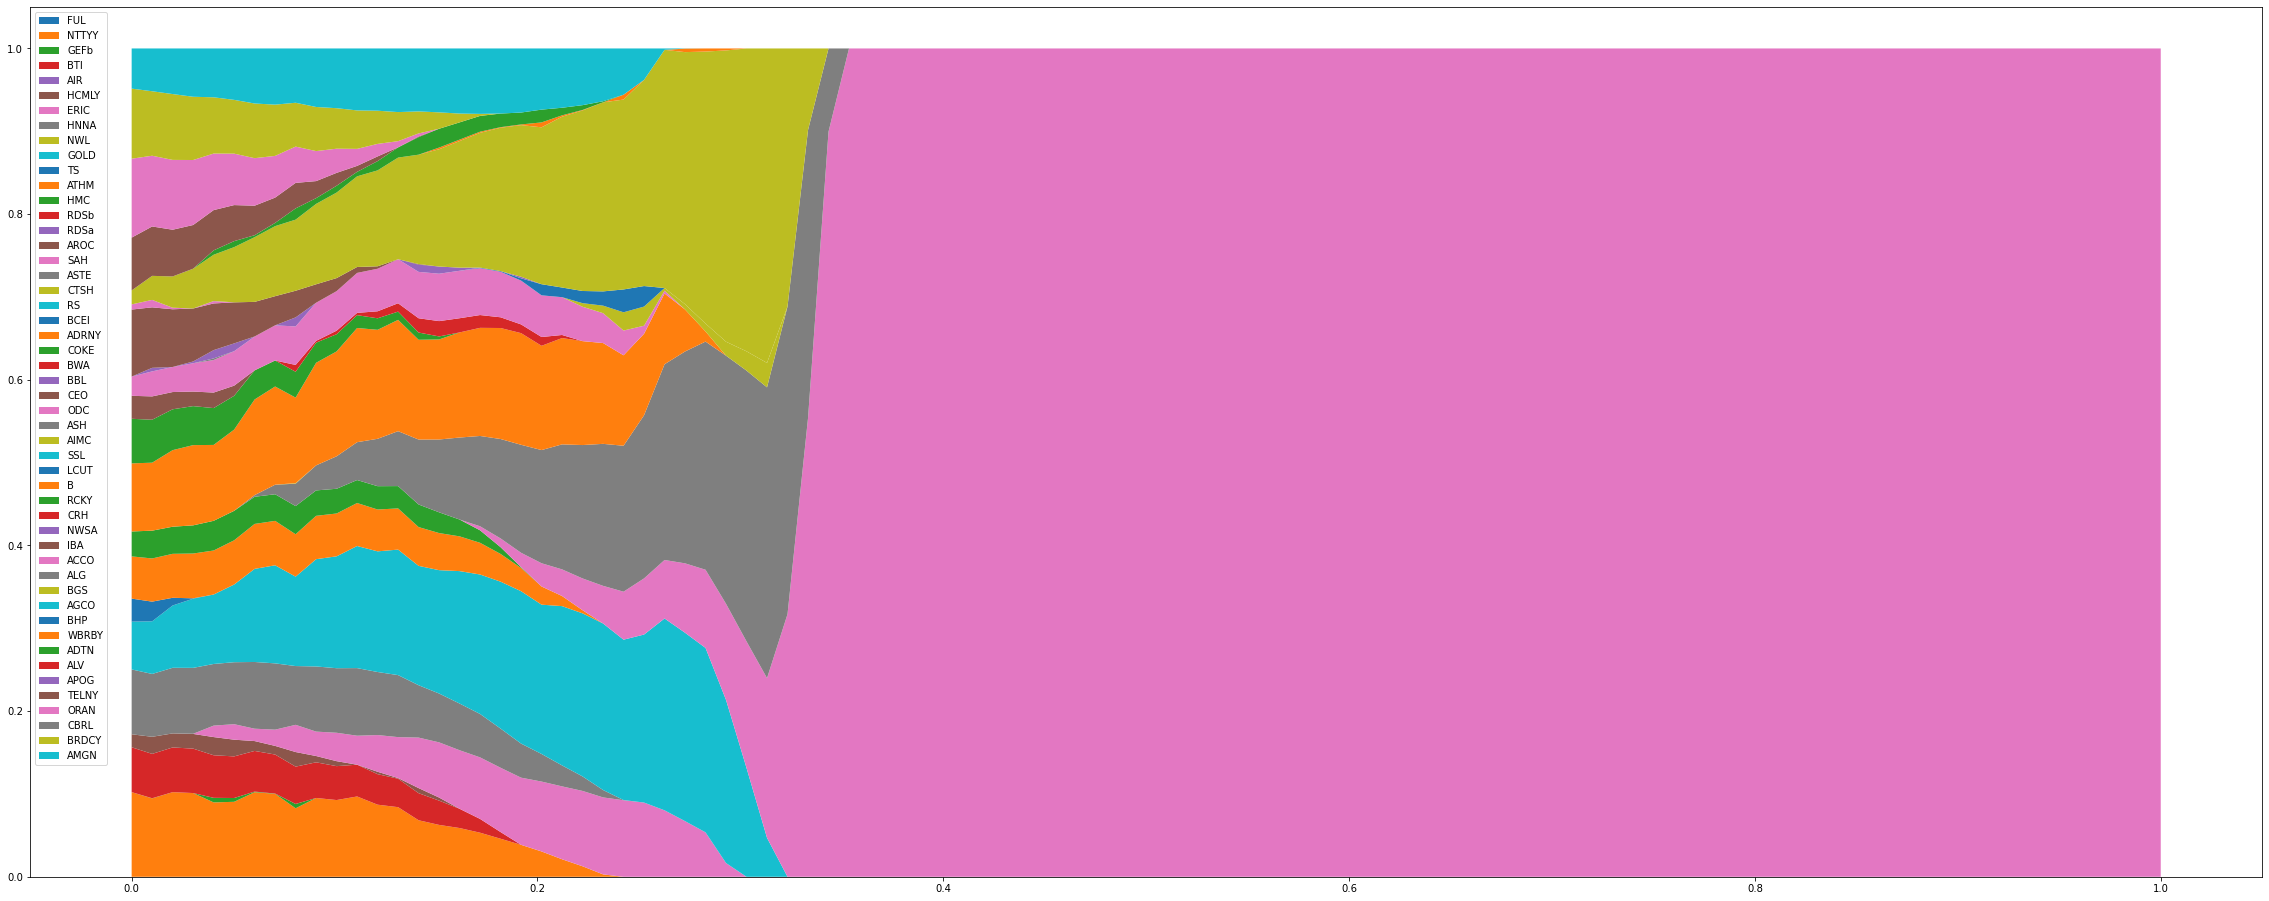

In [11]:
plt.figure(figsize=(40, 16))
plt.stackplot(rate, y, labels=labels)
plt.legend(loc='upper left')
plt.show()

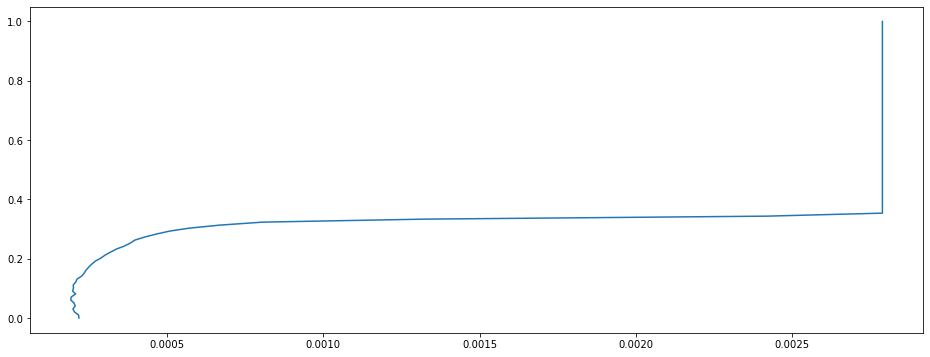

In [12]:
opti_vars = list(map(lambda res: res.fun, opti))
plt.figure(figsize=(16, 6))
plt.plot(opti_vars, rate)
plt.show()

In [31]:
def to_ndarray_invest(stock_data):
    features = []
    features.append(list(map(lambda x: x.beta, stock_data)))
    features.append(list(map(lambda x: x.debt_to_equity, stock_data)))
    features.append(list(map(lambda x: x.dividend_yield, stock_data)))
    features.append(list(map(lambda x: x.current_ratio, stock_data)))
    features.append(list(map(lambda x: x.roe, stock_data)))
    return np.array(features).T

def to_ndarray_trade(stock_data):
    features = []
    # features.append(list(map(lambda x: x.range_ln, stock_data)))
    features.append(list(map(lambda x: x.rsi, stock_data)))
    features.append(list(map(lambda x: x.volatility, stock_data)))
    features.append(list(map(lambda x: x.oscillation, stock_data)))
    features.append(list(map(lambda x: x.pe_ratio, stock_data)))
    return np.array(features).T

In [15]:
def get_correlation(data, high_coef=0.8):
    coercoef = np.corrcoef(data.T)
    for (i, row) in enumerate(coercoef):
        for (j, val) in enumerate(row):
            if i < j and abs(val) >= high_coef:
                print('High correlation detected for features {} and {}'.format(i, j))
    return coercoef

In [19]:
def draw_boxplot(X, labels, colors=None):
    # X[i] -- фичи для акции i
    # label[i] -- номер кластера акции i
    # X.shape = (#stocks, #features)

    fig, ax = plt.subplots(figsize=(10, 7))
    legend1, legend2 = [], []
    for label in range(1, max(labels) + 1):
        my = X[np.where(labels == label)]
        if colors is None:
            clr = list(np.random.random(3))
            clr2 = list(np.random.random(3))
        else:
            clr  = colors[label-1][0]
            clr2 = colors[label-1][1]
        bp = ax.boxplot(my, patch_artist=True)
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color=clr)
        for patch in bp['boxes']:
            patch.set(facecolor=clr2)
        legend1.append(bp["boxes"][0])
        legend2.append('Cluster ' + str(label-1))
    ax.legend(legend1, legend2)
    # plt.ylim(0, 1)
    plt.show()

In [20]:
def index_by_stock_data(stock_data_closes):
    # closes = []
    # for i in stock_data:
    #     closes.append(i.close)
    return scipy.stats.mstats.gmean(np.array(stock_data_closes))

In [21]:
from scipy.optimize import Bounds, minimize
import numpy as np
import matplotlib.pyplot as plt

def best_representative_of_cluster(stock_data, labels):
    stock_data_closes = []
    for stock_datum in stock_data:
        stock_data_closes.append(stock_datum.close)
    stock_data_closes = np.array(stock_data_closes)

    best_of_cluster = []
    for label in range(1, max(labels)+1):
        global_indices = np.array(list(range(len(stock_data))))[np.where(labels == label)]
        stock_data_closes_in_cluster = stock_data_closes[np.where(labels == label)]
        print("Cluster {}: {}".format(label, ' '.join(np.array(list(map(lambda x: x.stock, stock_data)))[np.where(labels == label)])))

        index_in_cluster = index_by_stock_data(stock_data_closes_in_cluster)

        x = np.ones(len(stock_data_closes_in_cluster)) * (1/len(stock_data_closes_in_cluster))

        def value(x):
            return (stock_data_closes_in_cluster.T @ x - index_in_cluster).std()

        sum_cons = {'type': 'eq',
                     'fun': lambda x: np.sum(x) - 1
                    }
        bnds = Bounds (np.zeros_like(x), np.ones_like(x))

        opti = minimize(value, x, method='SLSQP', constraints=[sum_cons], bounds=bnds)

        best_of_cluster.append((global_indices[np.argmax(opti.x)], np.max(opti.x)))
    return best_of_cluster

In [27]:
def make_analysis(stock_data_features):
    print("Correlation between features")
    print(get_correlation(stock_data_features))

    sc = sklearn.preprocessing.StandardScaler()
    sc.fit(stock_data_features)
    stock_data_features_normalized = sc.transform(stock_data_features)

    methods = ['single', 'ward', 'complete', 'average', 'weighted', 'centroid', 'median']
    metrics =  ['braycurtis', 'canberra', 'chebyshev', 'cityblock',
                'correlation', 'cosine', 'dice', 'euclidean', 'hamming',
                'jaccard', 'jensenshannon', 'kulsinski', 'mahalanobis', 'matching',
                'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean',
                'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']

    def labels_by_linked(linked, n_clusters):
        return scipy.cluster.hierarchy.fcluster(linked, t=n_clusters, criterion='maxclust')

    all_labels = []

    for (method, metric) in [('ward', 'euclidean'), ('complete', 'correlation'), ('average', 'braycurtis')]:
        linked = linkage(stock_data_features_normalized, method=method, metric=metric, optimal_ordering=True)

        labelList = range(0, len(stock_data_features_normalized))

        plt.figure(figsize=(10, 7))
        dendrogram(linked,
                    orientation='top',
                    labels=labelList,
                    distance_sort='descending',
                    show_leaf_counts=True)
        plt.title('{}, {}'.format(method, metric))
        plt.show()

        for n_clusters in range(2, 7):
            labels = labels_by_linked(linked, n_clusters)
            silhouette = sklearn.metrics.silhouette_score(stock_data_features_normalized, labels, metric=metric)
            print('Method {}, Metric {}, Number of clusters {}, Silhouette {}'.format(method, metric, n_clusters, silhouette))

        labels = labels_by_linked(linked, 6)
        all_labels.append(labels)
        # colors = [('tan', 'red'), ('blue', 'black'), ('green', 'cyan')]
        draw_boxplot(stock_data_features_normalized, labels)
        tree = sklearn.tree.DecisionTreeClassifier()
        tree.fit(stock_data_features, labels)
        plt.figure(figsize=(18, 12))
        sklearn.tree.plot_tree(tree, fontsize=10)
        best_of_cluster = best_representative_of_cluster(stock_data, labels)
        print('Best representatives of clusters')
        for (label, (i, coef)) in enumerate(best_of_cluster):
            print('Cluster {}: {} with coefficient {}'.format(label, stock_data[i].stock, coef))

        print('-'*100)
        print()
        print()

    similiarity_scores = np.zeros((len(all_labels), len(all_labels)))
    for (i, l1) in enumerate(all_labels):
        for (j, l2) in enumerate(all_labels):
            similiarity_scores[i][j] = sklearn.metrics.homogeneity_score(l1, l2)
    print(similiarity_scores)

Investment portfolio
Correlation between features
[[ 1.          0.20344828 -0.11595431  0.05280517  0.44245631]
 [ 0.20344828  1.          0.19067687 -0.32915889  0.32349237]
 [-0.11595431  0.19067687  1.         -0.2255575   0.14580705]
 [ 0.05280517 -0.32915889 -0.2255575   1.          0.16274799]
 [ 0.44245631  0.32349237  0.14580705  0.16274799  1.        ]]


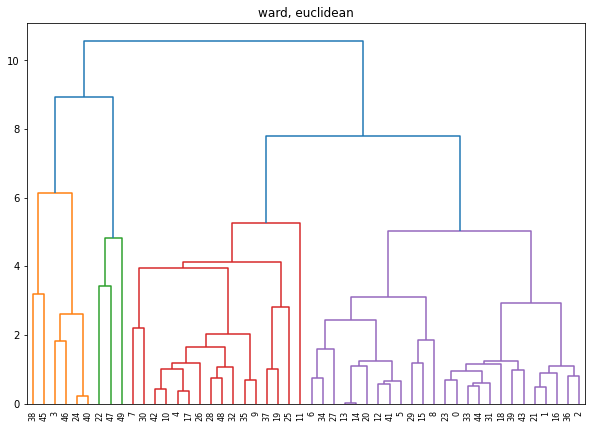

Method ward, Metric euclidean, Number of clusters 2, Silhouette 0.41301233903694623
Method ward, Metric euclidean, Number of clusters 3, Silhouette 0.4048272558051012
Method ward, Metric euclidean, Number of clusters 4, Silhouette 0.22699634402343535
Method ward, Metric euclidean, Number of clusters 5, Silhouette 0.2511467036798764
Method ward, Metric euclidean, Number of clusters 6, Silhouette 0.2355345090573923


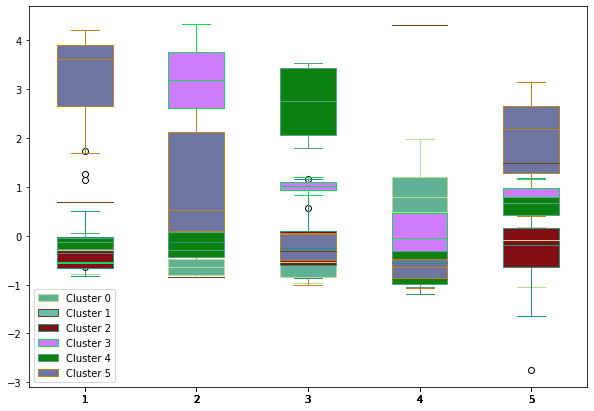

Cluster 1: AIR HNNA GOLD TS ASTE RS CEO ODC AIMC LCUT RCKY IBA ALG ADTN BRDCY
Cluster 2: ATHM
Cluster 3: FUL NTTYY GEFb HCMLY ERIC NWL HMC RDSb RDSa AROC SAH CTSH BCEI ADRNY BWA ASH SSL B CRH NWSA ACCO AGCO WBRBY ALV APOG
Cluster 4: BGS TELNY
Cluster 5: BTI BBL BHP ORAN
Cluster 6: COKE CBRL AMGN
Best representatives of clusters
Cluster 0: BRDCY with coefficient 0.20253555430556786
Cluster 1: ATHM with coefficient 1.0
Cluster 2: WBRBY with coefficient 0.1332613570234666
Cluster 3: TELNY with coefficient 0.553727621250719
Cluster 4: ORAN with coefficient 0.4058408308213041
Cluster 5: CBRL with coefficient 0.50311983644007
----------------------------------------------------------------------------------------------------




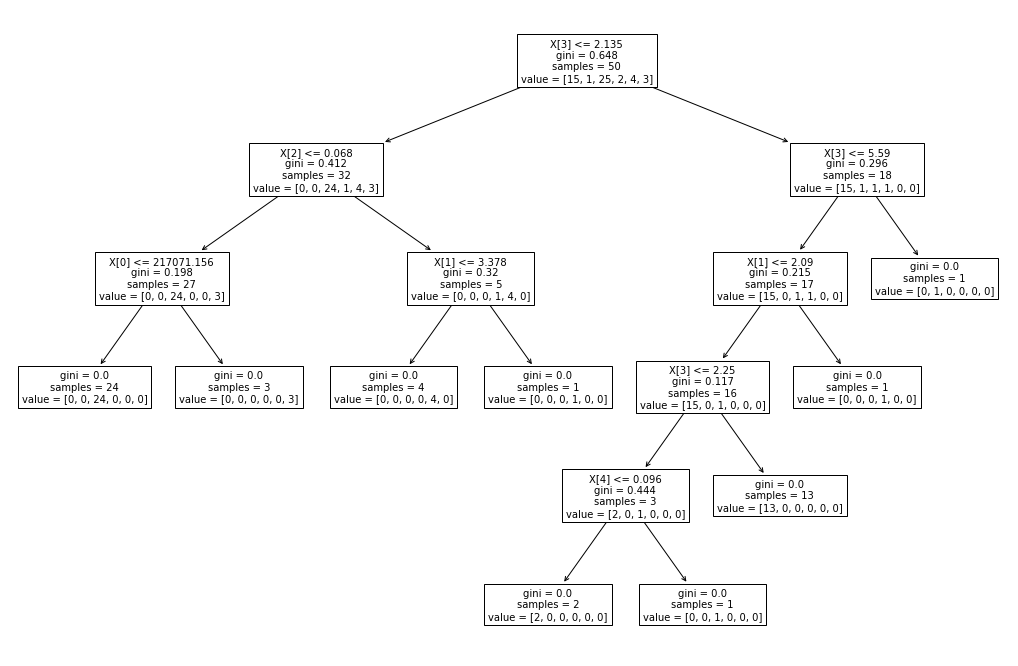

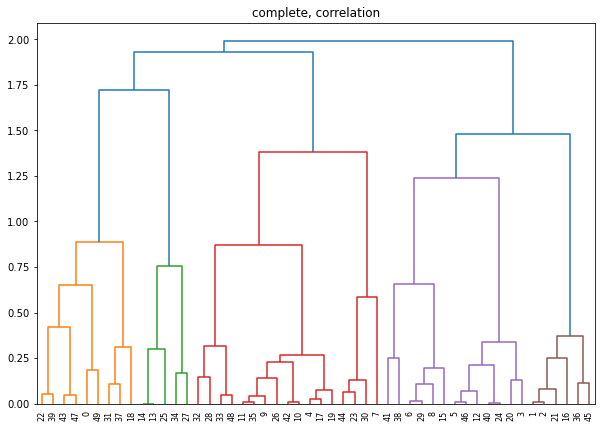

Method complete, Metric correlation, Number of clusters 2, Silhouette 0.41345421838946833
Method complete, Metric correlation, Number of clusters 3, Silhouette 0.3955470523163185
Method complete, Metric correlation, Number of clusters 4, Silhouette 0.35844100704184106
Method complete, Metric correlation, Number of clusters 5, Silhouette 0.3859224788210192
Method complete, Metric correlation, Number of clusters 6, Silhouette 0.4162183014325907


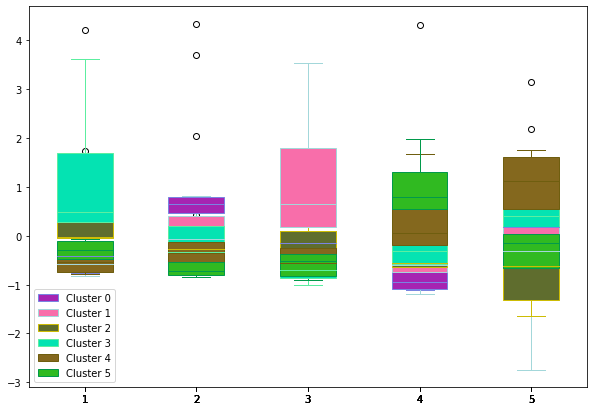

Cluster 1: NTTYY GEFb SAH ADRNY ACCO TELNY
Cluster 2: BTI HCMLY ERIC NWL HMC AROC BCEI BBL SSL BGS BHP WBRBY ORAN
Cluster 3: RDSb RDSa CEO ASH NWSA
Cluster 4: FUL CTSH COKE B ALG AGCO ALV CBRL AMGN
Cluster 5: HNNA BWA LCUT APOG
Cluster 6: AIR GOLD TS ATHM ASTE RS ODC AIMC RCKY CRH IBA ADTN BRDCY
Best representatives of clusters
Cluster 0: ACCO with coefficient 0.5260733139564124
Cluster 1: WBRBY with coefficient 0.18192700232735662
Cluster 2: NWSA with coefficient 0.33462021168246914
Cluster 3: AGCO with coefficient 0.21991966223372508
Cluster 4: LCUT with coefficient 0.4747857161331439
Cluster 5: ADTN with coefficient 0.21361967842562005
----------------------------------------------------------------------------------------------------




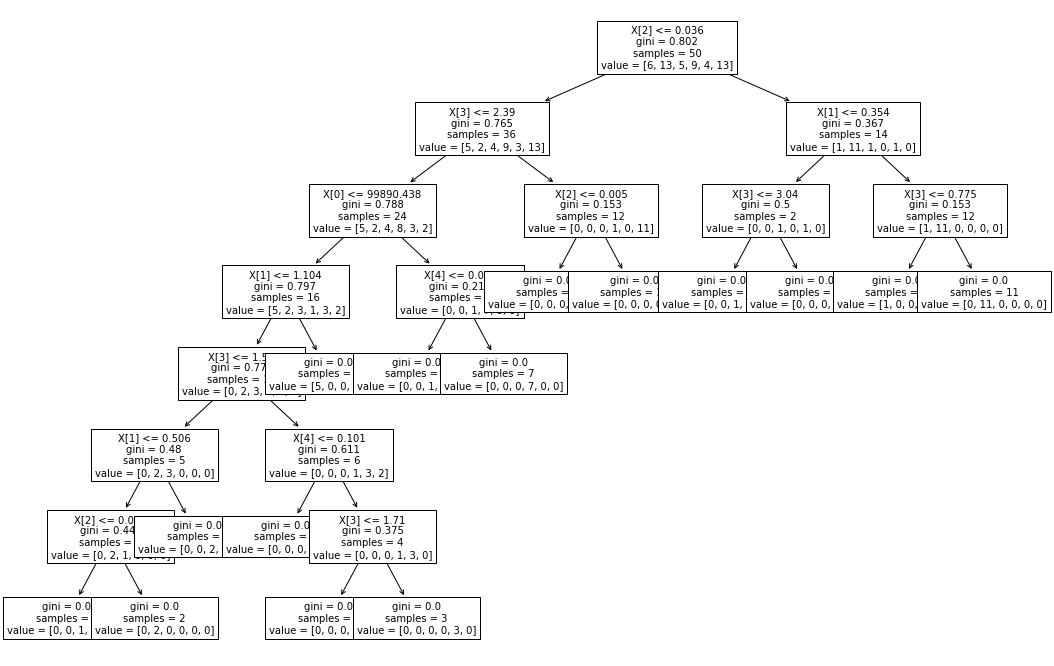

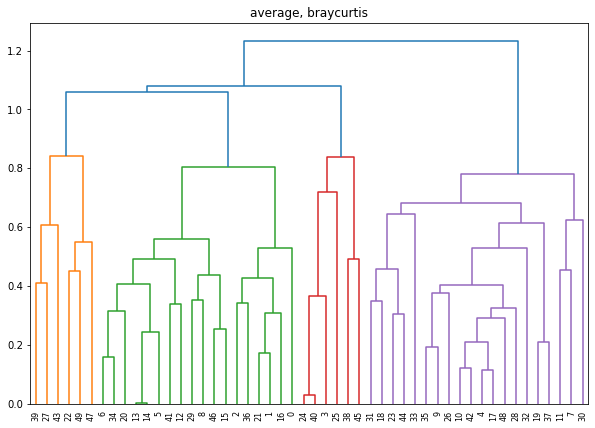

Method average, Metric braycurtis, Number of clusters 2, Silhouette 0.3425167405728347
Method average, Metric braycurtis, Number of clusters 3, Silhouette 0.27974992752498545
Method average, Metric braycurtis, Number of clusters 4, Silhouette 0.29071616486808943
Method average, Metric braycurtis, Number of clusters 5, Silhouette 0.2543623886317961
Method average, Metric braycurtis, Number of clusters 6, Silhouette 0.2467727999892304


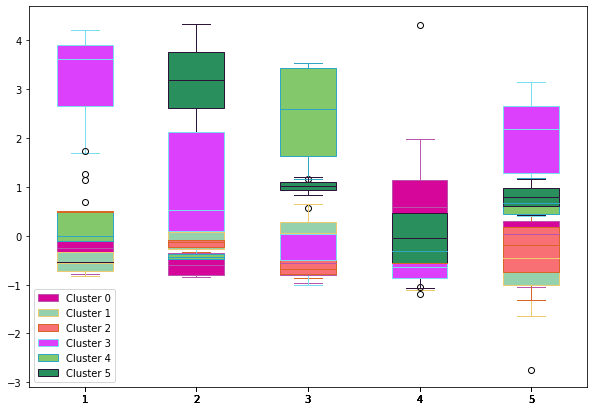

Cluster 1: AIR HNNA GOLD TS ATHM ASTE CTSH RS BWA ODC AIMC LCUT B RCKY CRH IBA ALG ADTN APOG BRDCY
Cluster 2: FUL NTTYY GEFb HCMLY ERIC NWL HMC RDSb RDSa AROC SAH BCEI ADRNY SSL NWSA ACCO WBRBY ORAN
Cluster 3: ASH AGCO ALV
Cluster 4: COKE CBRL AMGN
Cluster 5: BTI BBL CEO BHP
Cluster 6: BGS TELNY
Best representatives of clusters
Cluster 0: BRDCY with coefficient 0.11040469481855854
Cluster 1: WBRBY with coefficient 0.20056400596980245
Cluster 2: AGCO with coefficient 0.35983354879406315
Cluster 3: CBRL with coefficient 0.50311983644007
Cluster 4: BHP with coefficient 0.5535553011510814
Cluster 5: TELNY with coefficient 0.553727621250719
----------------------------------------------------------------------------------------------------


[[1.         0.46265639 0.67281163]
 [0.35073144 1.         0.47893909]
 [0.61664085 0.57903251 1.        ]]


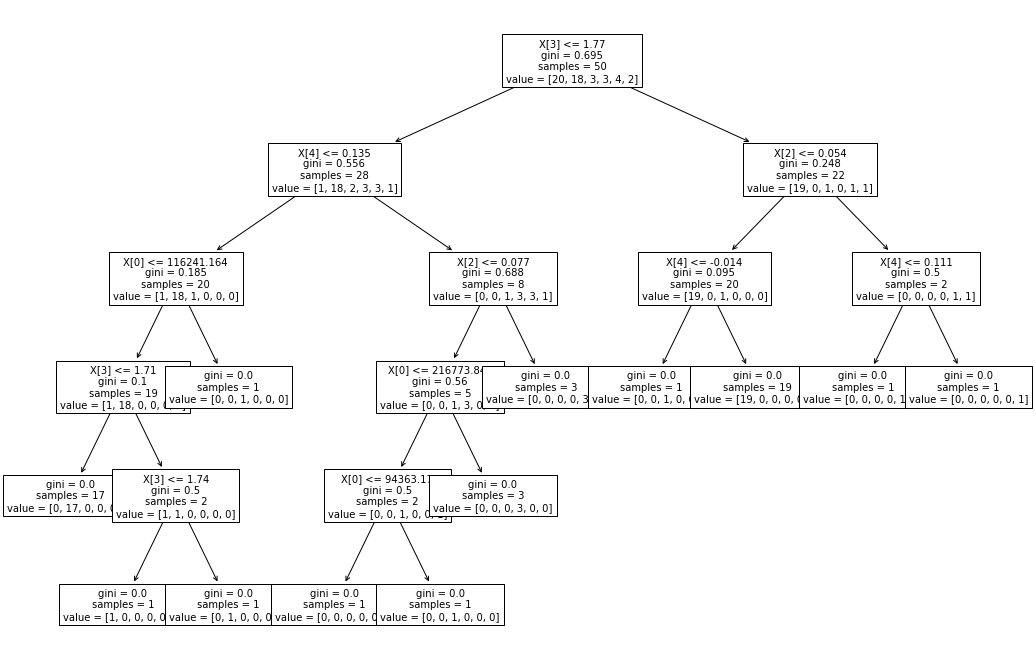

In [28]:
stock_data_features_invest = to_ndarray_invest(stock_data)
print('Investment portfolio')
make_analysis(stock_data_features_invest)

Trading portfolio
Correlation between features
[[ 1.         -0.16059783  0.07473589 -0.06684081]
 [-0.16059783  1.         -0.14418848 -0.08818576]
 [ 0.07473589 -0.14418848  1.         -0.16963662]
 [-0.06684081 -0.08818576 -0.16963662  1.        ]]


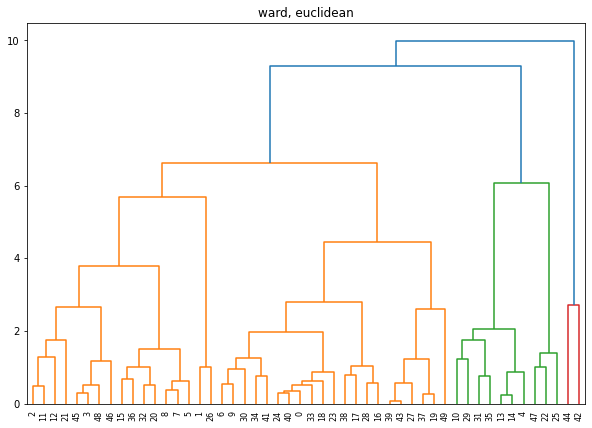

Method ward, Metric euclidean, Number of clusters 2, Silhouette 0.5909058538571407
Method ward, Metric euclidean, Number of clusters 3, Silhouette 0.36735790433355264
Method ward, Metric euclidean, Number of clusters 4, Silhouette 0.2654528077973729
Method ward, Metric euclidean, Number of clusters 5, Silhouette 0.3038806190330065
Method ward, Metric euclidean, Number of clusters 6, Silhouette 0.31454327699769025


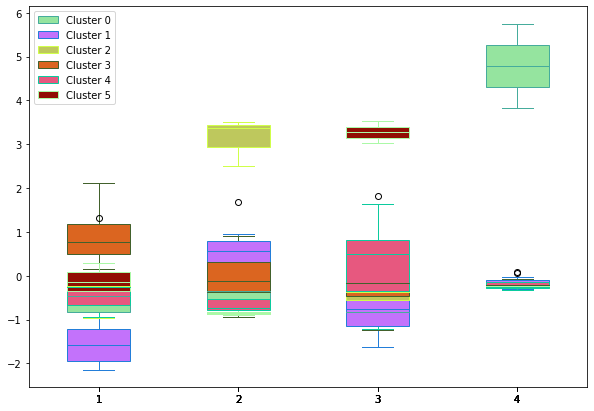

Cluster 1: ADTN APOG
Cluster 2: AIR TS RDSb RDSa SSL B IBA
Cluster 3: COKE CEO CBRL
Cluster 4: FUL ERIC GOLD SAH ASTE CTSH RS BWA BBL ASH AIMC LCUT CRH NWSA ALG BGS AGCO BHP WBRBY ALV AMGN
Cluster 5: GEFb BTI HCMLY HNNA NWL ATHM HMC AROC BCEI ADRNY RCKY ACCO TELNY ORAN BRDCY
Cluster 6: NTTYY ODC
Best representatives of clusters
Cluster 0: ADTN with coefficient 0.7061092321882978
Cluster 1: SSL with coefficient 0.4547512631804683
Cluster 2: CBRL with coefficient 0.477662120612258
Cluster 3: LCUT with coefficient 0.21682288413511008
Cluster 4: AROC with coefficient 0.15139247277596948
Cluster 5: NTTYY with coefficient 0.5853984586437626
----------------------------------------------------------------------------------------------------




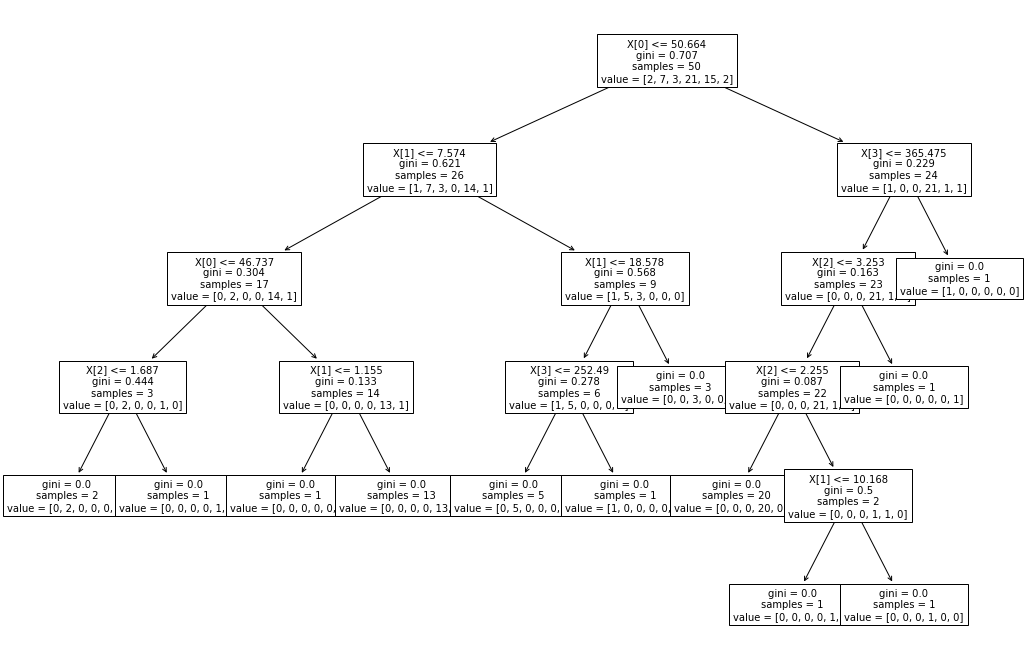

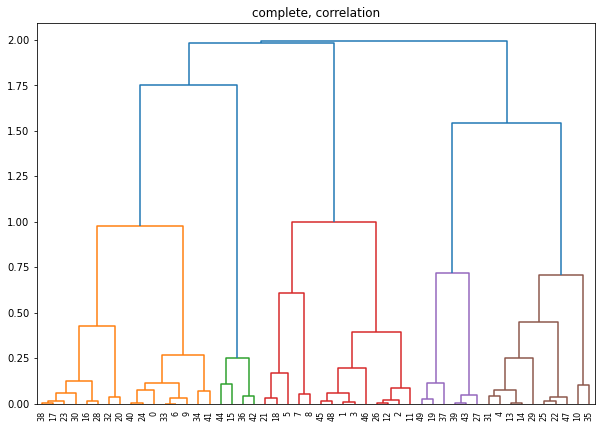

Method complete, Metric correlation, Number of clusters 2, Silhouette 0.4576844834786105
Method complete, Metric correlation, Number of clusters 3, Silhouette 0.5613667082816044
Method complete, Metric correlation, Number of clusters 4, Silhouette 0.5850368692880568
Method complete, Metric correlation, Number of clusters 5, Silhouette 0.6443627847468085
Method complete, Metric correlation, Number of clusters 6, Silhouette 0.5987998318283797


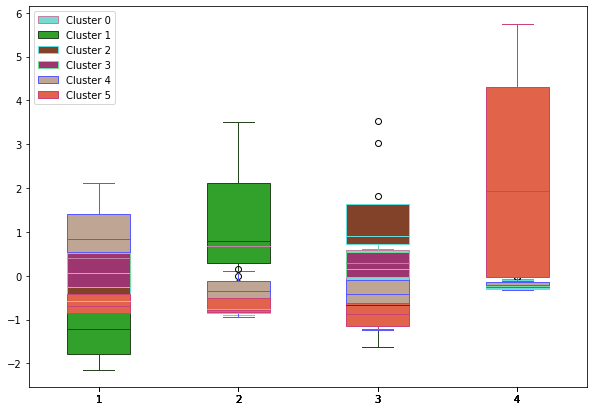

Cluster 1: RS ASH ALG AGCO ALV AMGN
Cluster 2: AIR TS RDSb RDSa COKE CEO SSL B IBA CBRL
Cluster 3: NTTYY GEFb BTI ATHM HMC ODC TELNY ORAN BRDCY
Cluster 4: HCMLY HNNA NWL CTSH ADRNY
Cluster 5: FUL ERIC GOLD SAH ASTE BCEI BWA BBL AIMC LCUT RCKY CRH NWSA BGS BHP WBRBY
Cluster 6: AROC ACCO ADTN APOG
Best representatives of clusters
Cluster 0: ALV with coefficient 0.24883525940865134
Cluster 1: SSL with coefficient 0.3032758664221671
Cluster 2: ORAN with coefficient 0.19815000624949353
Cluster 3: HNNA with coefficient 0.31373414612923073
Cluster 4: LCUT with coefficient 0.19281495724090958
Cluster 5: AROC with coefficient 0.4159327908819521
----------------------------------------------------------------------------------------------------




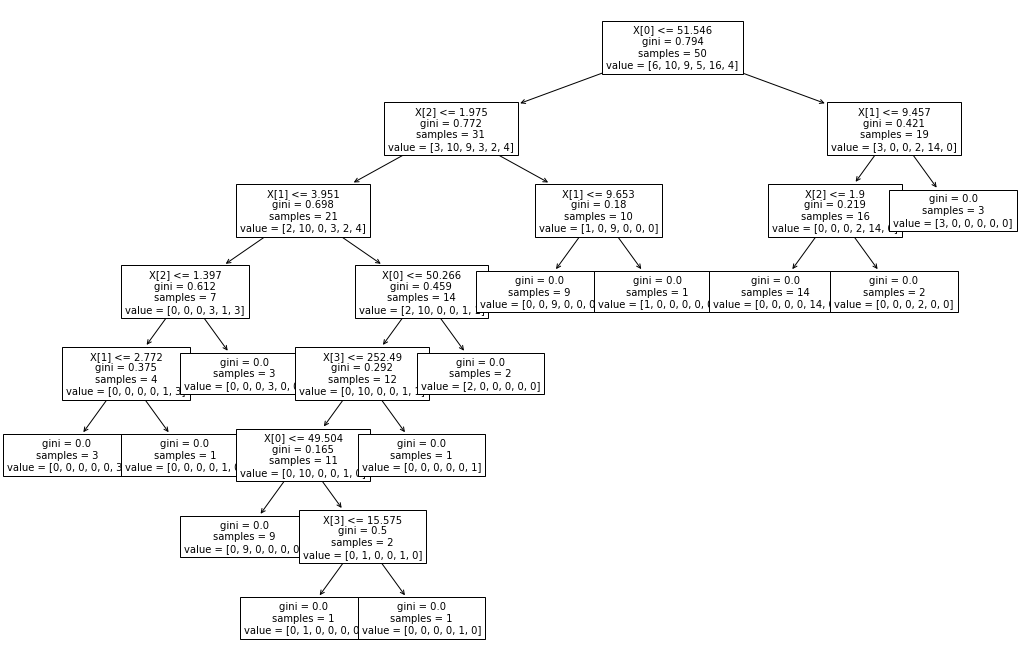

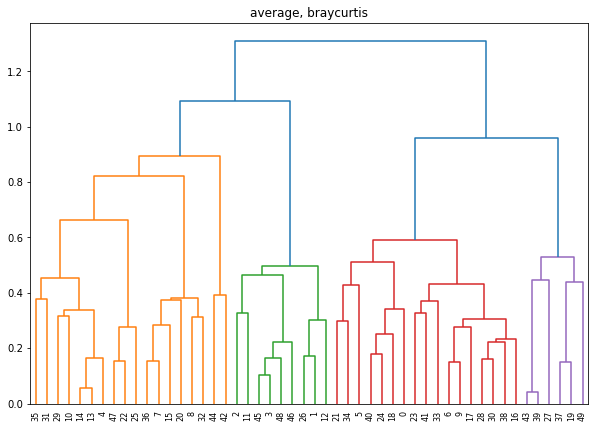

Method average, Metric braycurtis, Number of clusters 2, Silhouette 0.3848877639544077
Method average, Metric braycurtis, Number of clusters 3, Silhouette 0.3387200794156625
Method average, Metric braycurtis, Number of clusters 4, Silhouette 0.3387833476706654
Method average, Metric braycurtis, Number of clusters 5, Silhouette 0.34290457086299697
Method average, Metric braycurtis, Number of clusters 6, Silhouette 0.3641254959242653


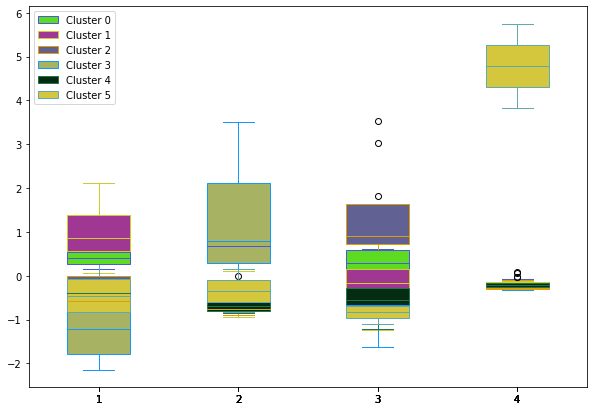

Cluster 1: RS ASH ALG AGCO ALV AMGN
Cluster 2: FUL HCMLY ERIC GOLD SAH ASTE CTSH ADRNY BWA BBL AIMC LCUT CRH NWSA BGS BHP WBRBY
Cluster 3: NTTYY GEFb BTI ATHM HMC ODC TELNY ORAN BRDCY
Cluster 4: AIR TS RDSb RDSa COKE CEO SSL B IBA CBRL
Cluster 5: HNNA NWL AROC BCEI RCKY ACCO
Cluster 6: ADTN APOG
Best representatives of clusters
Cluster 0: ALV with coefficient 0.24883525940865134
Cluster 1: LCUT with coefficient 0.21329415161367848
Cluster 2: ORAN with coefficient 0.19815000624949353
Cluster 3: SSL with coefficient 0.3032758664221671
Cluster 4: AROC with coefficient 0.26779680698719943
Cluster 5: ADTN with coefficient 0.7061092321882978
----------------------------------------------------------------------------------------------------


[[1.         0.68917768 0.76128613]
 [0.58476914 1.         0.82741543]
 [0.6645042  0.8511776  1.        ]]


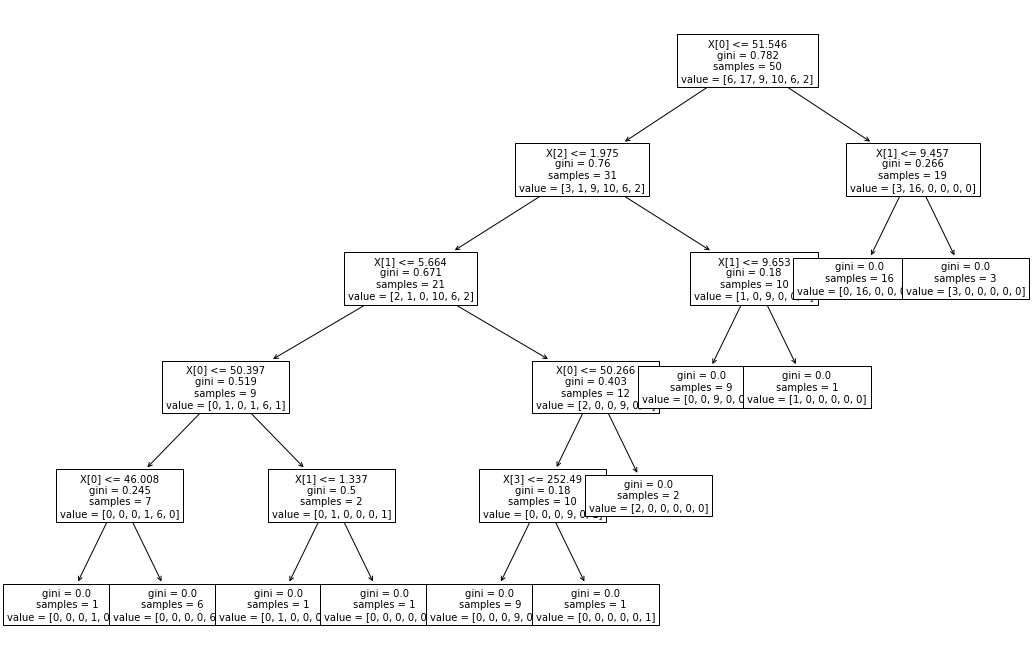

In [32]:
stock_data_features_trade = to_ndarray_trade(stock_data)
print('Trading portfolio')
make_analysis(stock_data_features_trade)